In [ ]:
import zipfile
z = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/archive.zip")
z.extractall()

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
from sklearn.metrics import classification_report
%matplotlib inline
plt.style.use('ggplot')


**Sobel**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def apply_sobel(image):
    # Apply Sobel operator
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute gradient magnitude
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalize
    sobel_magnitude = np.uint8(255 * sobel_magnitude / np.max(sobel_magnitude))

    return sobel_magnitude

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Warning: Image {img_path} is empty or corrupt.")
                    continue


                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Apply Sobel preprocessing
                sobel_img = apply_sobel(resized_arr)

                # Add to the dataset
                data.append([sobel_img, class_num])

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

In [ ]:
train = get_data("chest_xray/chest_xray/train")
test = get_data("chest_xray/chest_xray/test")
val = get_data("chest_xray/chest_xray/val")

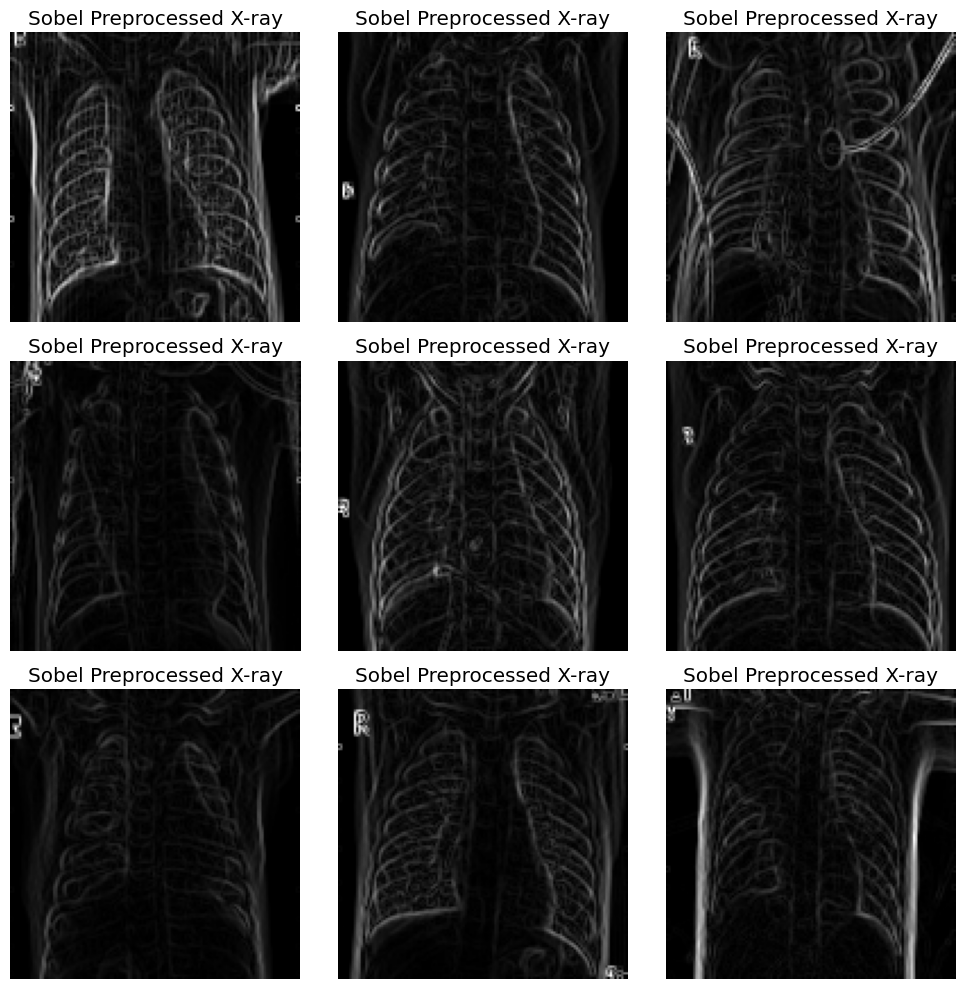

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    sobel_img = train[i][0]
    plt.imshow(sobel_img, cmap='gray')
    plt.axis("off")
    plt.title("Sobel Preprocessed X-ray")
plt.tight_layout()
plt.show()


In [ ]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

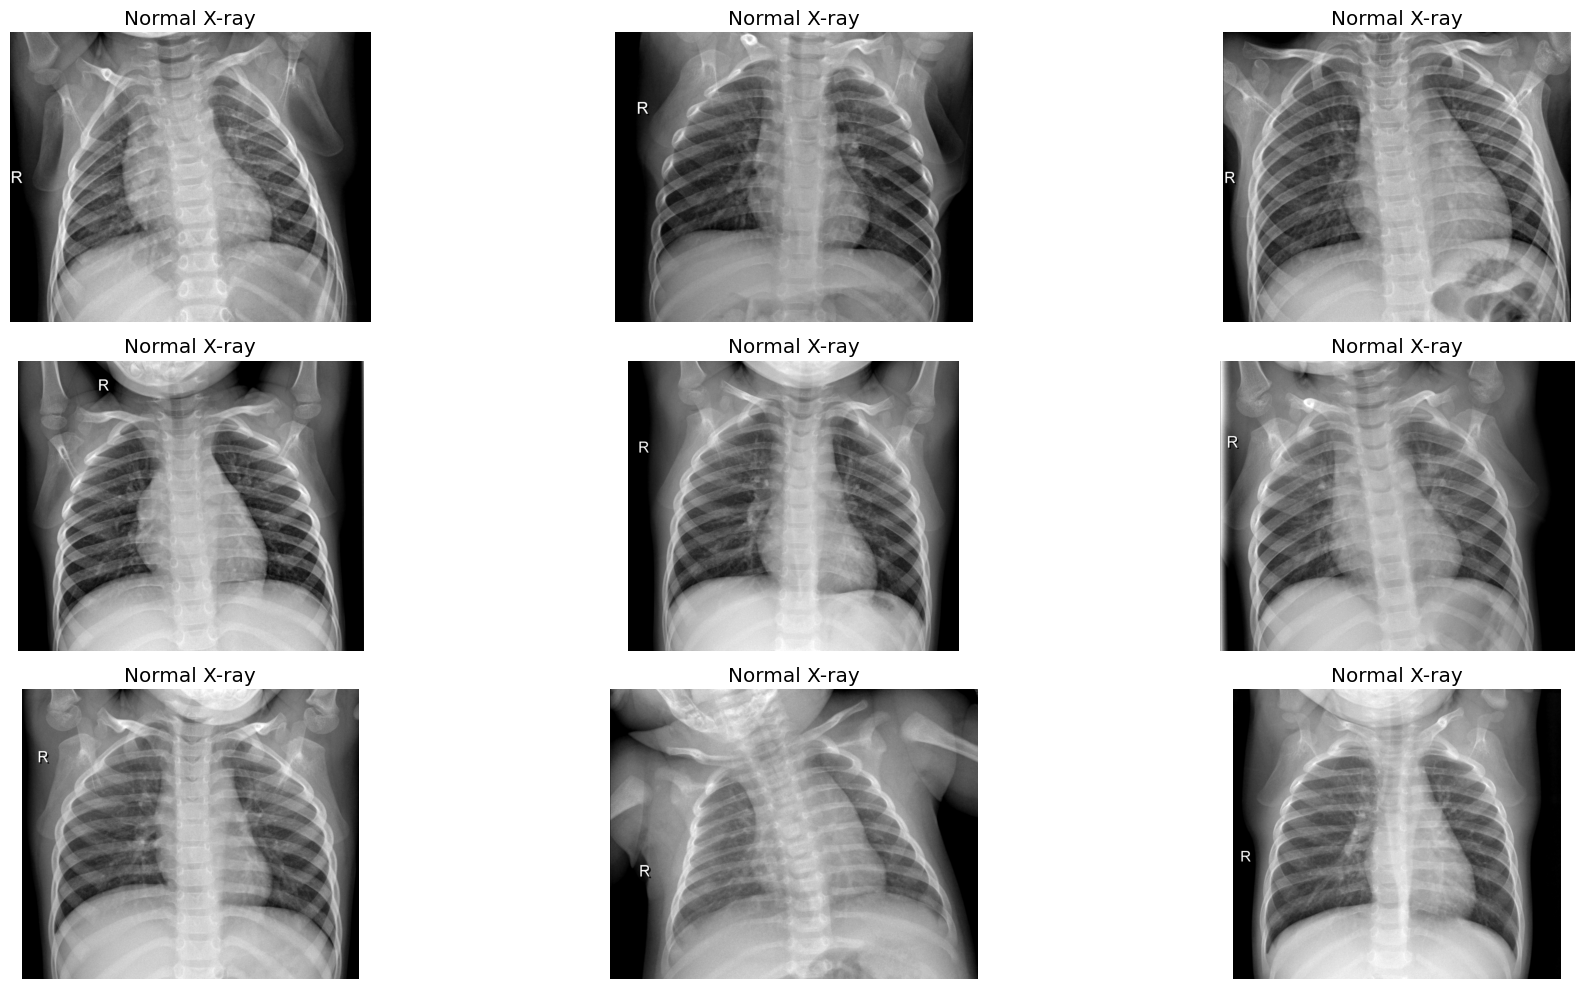

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

<Axes: xlabel='count'>

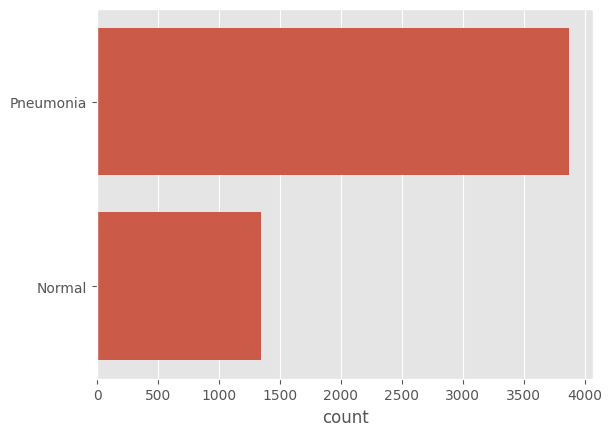

In [ ]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train = np.array([i[0] for i in train])
y_train = np.array([i[1] for i in train])

X_test = np.array([i[0] for i in test])
y_test = np.array([i[1] for i in test])

X_val = np.array([i[0] for i in val])
y_val = np.array([i[1] for i in val])

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train_combined = np.vstack([X_train, X_val])
y_train_combined = np.hstack([y_train, y_val])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_combined, y_train_combined)

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7772435897435898
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85       390
           1       0.91      0.45      0.60       234

    accuracy                           0.78       624
   macro avg       0.83      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = nn_model.fit(X_train_combined, y_train_combined, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f"Neural Network Test Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8727 - loss: 0.5020 - val_accuracy: 0.7660 - val_loss: 1.7370
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9597 - loss: 0.1541 - val_accuracy: 0.7724 - val_loss: 1.7501
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9774 - loss: 0.0719 - val_accuracy: 0.7660 - val_loss: 2.0069
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9837 - loss: 0.0535 - val_accuracy: 0.7356 - val_loss: 2.6866
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9909 - loss: 0.0331 - val_accuracy: 0.7644 - val_loss: 2.5491
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9931 - loss: 0.0196 - val_accuracy: 0.7340 - val_loss: 3.4848
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9907 - loss: 0.0267 - val_accuracy: 0.7356 - val_loss: 3.7031
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9963 - loss: 0.0136 - val_acc

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7307692307692307
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.70      0.98      0.82       390
           1       0.92      0.31      0.46       234

    accuracy                           0.73       624
   macro avg       0.81      0.65      0.64       624
weighted avg       0.79      0.73      0.69       624



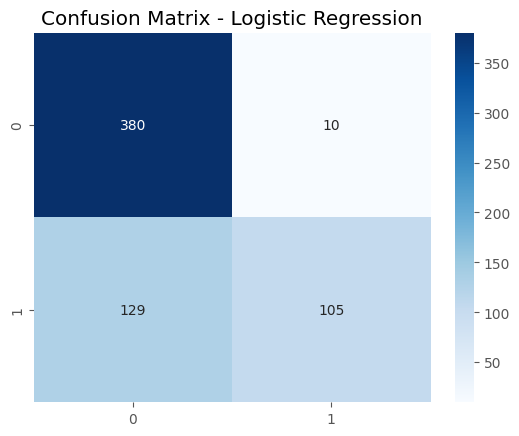

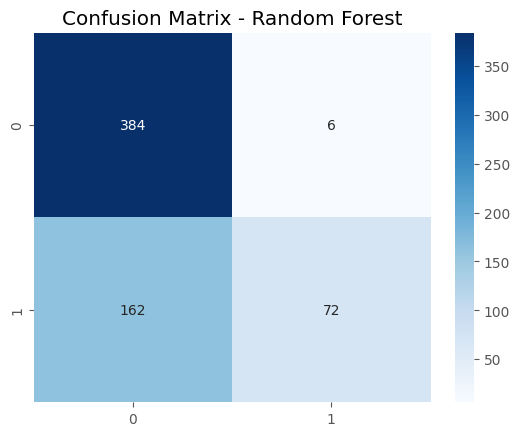

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


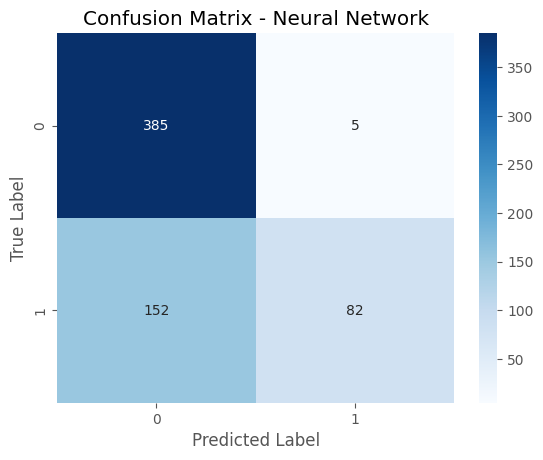

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

y_pred_nn = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)  # Convert probabilities to binary values (0 or 1)


cm_nn = confusion_matrix(y_test, y_pred_nn)

# Plot
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       390
           1       0.91      0.45      0.60       234

    accuracy                           0.78       624
   macro avg       0.83      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       390
           1       0.92      0.31      0.46       234

    accuracy                           0.73       624
   macro avg       0.81      0.65      0.64       624
weighted avg       0.79      0.73      0.69       624

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       390
           1       0.94      0.35      0.51       234

    accuracy                           0.75       624
   macro a

**Gaussian Blurring**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=1):

    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Warning: Image {img_path} is empty or corrupt.")
                    continue

                # Resize
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Apply Gaussian Blurring
                blurred_img = apply_gaussian_blur(resized_arr)


                data.append([blurred_img, class_num])

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Use the updated function to load the datasets
train = get_data("chest_xray/chest_xray/train")
test = get_data("chest_xray/chest_xray/test")
val = get_data("chest_xray/chest_xray/val")


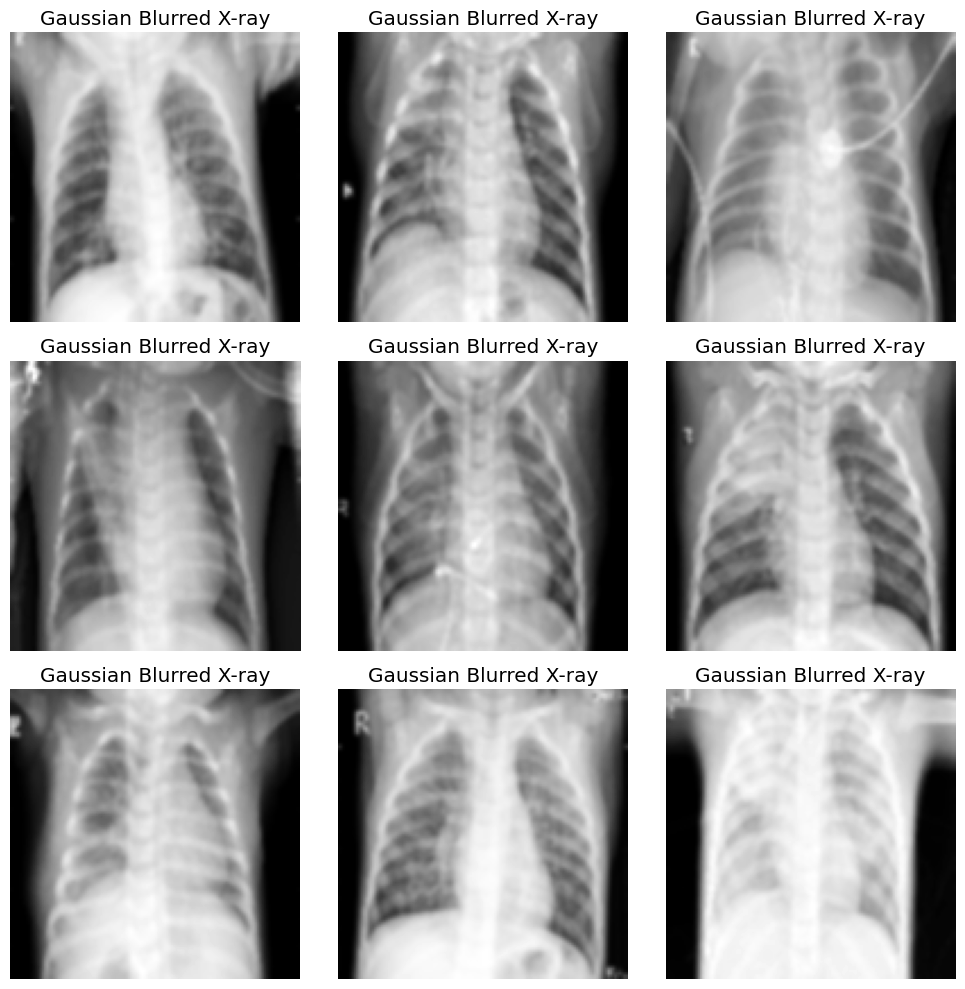

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    blurred_img = train[i][0]
    plt.imshow(blurred_img, cmap='gray')
    plt.axis("off")
    plt.title("Gaussian Blurred X-ray")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train = np.array([i[0] for i in train])
y_train = np.array([i[1] for i in train])

X_test = np.array([i[0] for i in test])
y_test = np.array([i[1] for i in test])

X_val = np.array([i[0] for i in val])
y_val = np.array([i[1] for i in val])

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train_combined = np.vstack([X_train, X_val])
y_train_combined = np.hstack([y_train, y_val])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_combined, y_train_combined)

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7532051282051282
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.72      0.99      0.83       390
           1       0.94      0.36      0.52       234

    accuracy                           0.75       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.80      0.75      0.72       624



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = nn_model.fit(X_train_combined, y_train_combined, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f"Neural Network Test Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8712 - loss: 1.0877 - val_accuracy: 0.7404 - val_loss: 2.6716
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9404 - loss: 0.4505 - val_accuracy: 0.7917 - val_loss: 2.3056
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9459 - loss: 0.2901 - val_accuracy: 0.7885 - val_loss: 1.8372
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9509 - loss: 0.2079 - val_accuracy: 0.7837 - val_loss: 1.6273
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9603 - loss: 0.1117 - val_accuracy: 0.7580 - val_loss: 1.5119
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9713 - loss: 0.0858 - val_accuracy: 0.7804 - val_loss: 1.4292
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9691 - loss: 0.0877 - val_accuracy: 0.7804 - val_loss: 1.4603
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9687 - loss: 0.1107 - val_ac

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_combined)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7724358974358975
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.74      0.99      0.84       390
           1       0.96      0.41      0.57       234

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



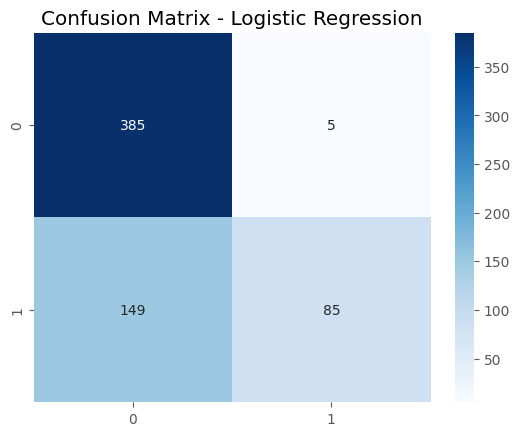

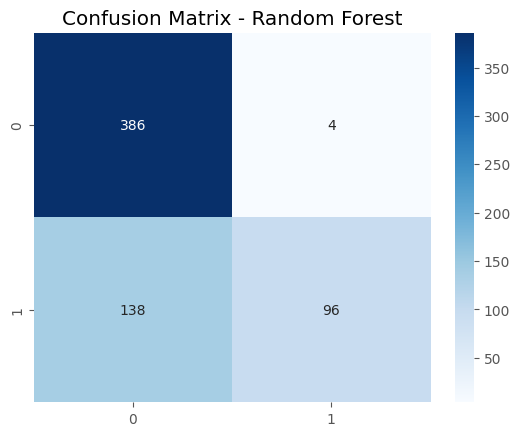

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


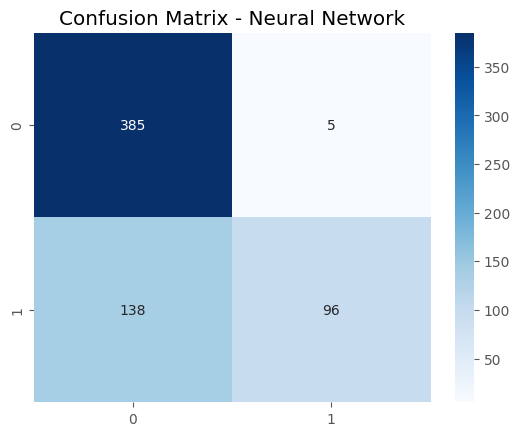

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for LR
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

y_pred_nn_prob = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.show()


In [ ]:
# LR report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# RF report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# NN report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       390
           1       0.94      0.36      0.52       234

    accuracy                           0.75       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.80      0.75      0.72       624

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.84       390
           1       0.96      0.41      0.57       234

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.84       390
           1       0.95      0.41      0.57       234

    accuracy                           0.77       624
   macro a